In [2]:
import numpy as np
import matplotlib.pyplot as plt
import helpers as hp
import simulate as si

# Toy Problem
Constant heat at the bottom and the top is room temperature.

In [6]:
# Define parameters 
b0 = 150 # u(0,t)= b0 (boundary cond)
bL = 20 # u(L,t)= bL (boundary cond)
D = 0.143*10**(-6) # thermal diffusivity coefficient - in the liquid
a = 0 # heat transfer coefficient of liquid through container to air - for sink term along sides of can
T = 1800 # final time 
L = 0.13 # Length (i.e. height) of the can
Nt_points = 2000    # number of timesteps
Nx_points = 100   # number of spaces in x

u_inf = bL # air temperature - for this problem we say that the temperature at end of rod is fixed at air temp

# Set initial condition
u0 = np.zeros(Nx_points)
u0[0] = b0
u0[1:] = bL*np.ones(Nx_points-1)

# Set up time related functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

# run simulation
U = si.simulate_dirichlet_sink(u0, lambda t: b0, D, T, Nt_points, L, Nx_points, 0)

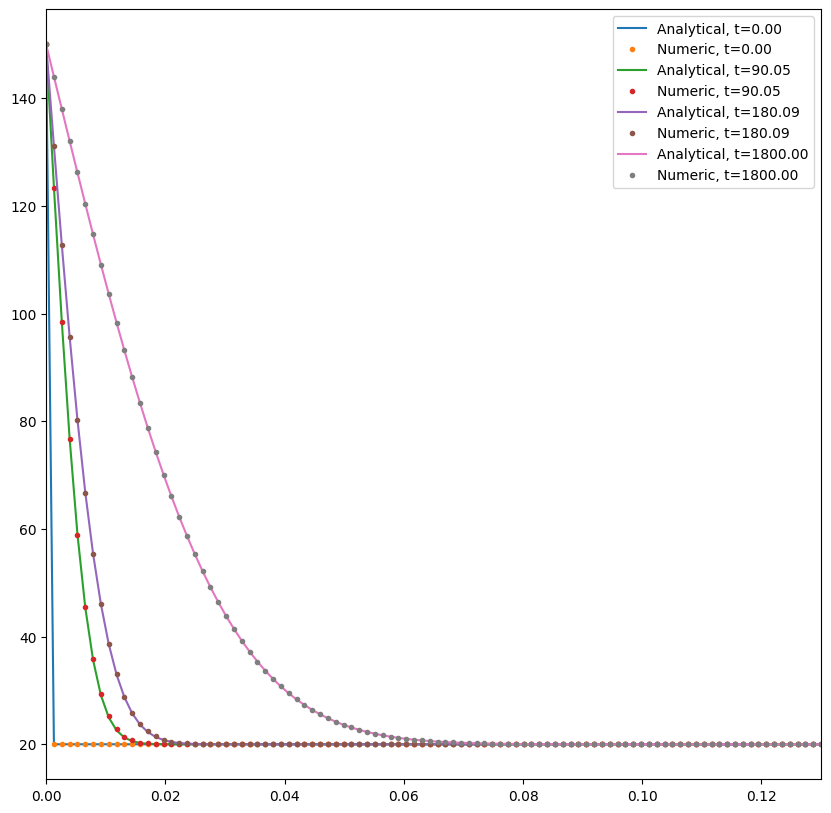

In [7]:
# Compare to analytic solution

U_analyt = si.create_analytic_toy_fn(b0, bL, L, D)
x = np.linspace(0,L,Nx_points)

fig, ax = plt.subplots(figsize = (10,10))

for i in (0, Nt_points//20, Nt_points//10, Nt_points - 1):
    t = index_to_time(i)
    ax.plot(x, U_analyt(x, t), "-", label = f"Analytical, {t=:.2f}")
    ax.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
    
plt.xlim(0,L)
plt.legend()
plt.show()

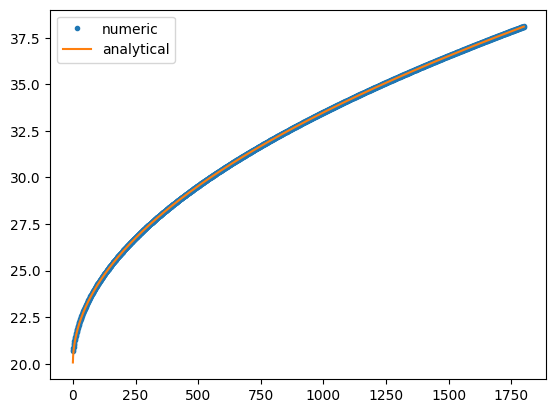

In [8]:
# Observe the average temperature of the numerical and analytic solutions
def create_numeric_avtemp_fn(U, Nt_points, dx):
    """Returns the numeric function describing the average temperature at times t"""
    def avg_temp_numeric(t):
        """t is in seconds. Must be an np.array"""
        Ut = U[:, time_to_index(t)]

        # trapezoid rule
        avtemp = np.sum(dx * 0.5 * (Ut[:-1, :] + Ut[1:, :]), axis = 0) # sum along columns, i.e. sum along all x
        return avtemp
    
    return avg_temp_numeric

avg_temp_analytic = si.create_analytic_avg_temp(b0, bL, L, D)
avg_temp_numeric = create_numeric_avtemp_fn(U, Nt_points, dx = 1/(Nx_points - 1))

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.plot(t, avg_temp_analytic(t), "-", label = "analytical")
plt.legend()
plt.show()

In [9]:
# Measure how long it takes to reach a certain temperature
def time_to_temp(avg_temps, temp):
    for i, avg_temp in enumerate(avg_temps):
        if avg_temp > temp:
            return index_to_time(i)
        
    print(f"None of the given average temperatures is above {temp}.")
    return None

num_tto35 = time_to_temp(avg_temp_numeric(t), 35)
analyt_tto35 = time_to_temp(avg_temp_analytic(t), 35)

print(f"{num_tto35=}, {analyt_tto35}")

# Find maximum average temperature
averages = np.zeros(Nt_points)

k = np.linspace(0, T, Nt_points)
for k in range(T):
    averages[k] = avg_temp_numeric(np.array([k]))

print('Maximum average temperature is :',averages.max())

num_tto35=1234.5172586293147, 1236.3181590795398
Maximum average temperature is : 38.10528943722328


C:\Users\marka\AppData\Local\Temp\ipykernel_20016\3218754521.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  averages[k] = avg_temp_numeric(np.array([k]))


# Observations
- The numerical solution of the diffusion equation and the integral and accurate compared to the analytic solution
- When the bottom of the can is 150 and the top is 20 the liquid takes a very long time to warm up, it takes more that 20 minutes to reach an average temperature of 35 degrees
- Maximum average temperature is 38 degrees, not ideal

# Realistic Model
Examine what happens when there is a sink term and a Newton cooling top boundary condition and it takes time for the bottom of the can to heat up

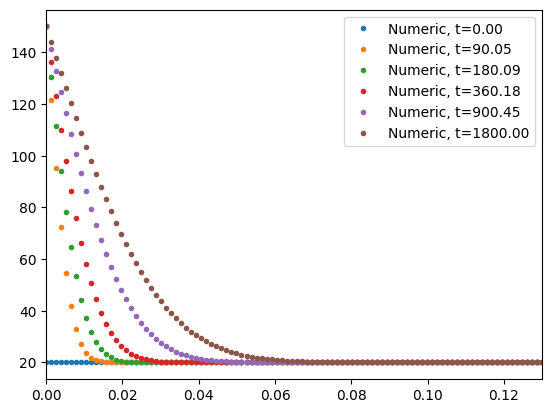

In [16]:
# Define the function that causes the heating element to take time to warm up
def b0(t):
    if t <= 10:
        return (150 - 20)*(t/60) # TODO: I think we want divide by 10 here - Mark
    else:
        return 150

W = 0.0005 # Thickness of the top of the can
r1 = 0.04 # Radius of the liquid in the can (up to the interior surface of the can)
r2 = 0.0405 # Radius of the liquid in the can (up to the exterior of the can)
kS = 16 # Thermal conductivity of stainless steel
hA = 750 # Heat transfer coefficient of water
hB = 10 # Heat transfer coefficient of air
kW = 0.6 # Thermal conductivity of water

a = hp.sink_HTC(L, r1, r2, kS, hA, hB)/100 # Why do we divide by 100 here? - Mark
h = hp.boundary_condition_HTC(W, r1, kS, hA, hB)

# Set initial condition
u0 = np.zeros(Nx_points)
u0[0] = 20
u0[1:] = u_inf*np.ones(Nx_points-1)

# Simulate the solution
U = si.simulate_sink_with_fancy_bcs(u0, b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf, 2*r1)

# Redo time functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

for i in (0, Nt_points//20, Nt_points//10, Nt_points//5, Nt_points//2, Nt_points - 1):
    t = index_to_time(i)
    plt.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
plt.xlim(0,L)   
plt.legend()
plt.show()

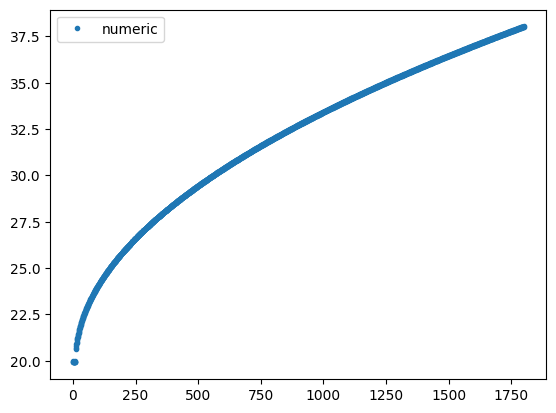

In [11]:
# Check average temperature
avg_temp_numeric = create_numeric_avtemp_fn(U, Nt_points, dx = 1/(Nx_points - 1))

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.legend()
plt.show()

In [12]:
num_tto25 = time_to_temp(avg_temp_numeric(t), 25)

print(f"{num_tto25=}")

# Find maximum average temperature
k = np.linspace(0, T, Nt_points)
for k in range(T):
    averages[k] = avg_temp_numeric(np.array([k]))

print('Maximum average temperature is :',averages.max())

num_tto25=147.67383691845922


C:\Users\marka\AppData\Local\Temp\ipykernel_20016\2560113633.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  averages[k] = avg_temp_numeric(np.array([k]))


Maximum average temperature is : 38.03485901614091


# Observations
- Taking into consideration heat loss out the top and sides and a heating element that takes time to heat up produces results worse than the toy model
- This model, in the same amount of time, does not get as warm as the toy model
- The maximum average temperature is 26 degrees; worse
- If we want the self heating can to perform better the can must be better insulated

# More insulated but not completely
This model has a heating element that takes time to warm up and looses heat out of the top but not out of the sides

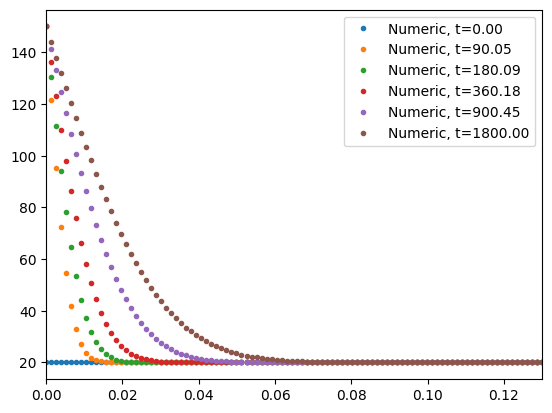

In [17]:
a = 0 # Turn off the sink term

# Simulate the solution
U = si.simulate_sink_with_fancy_bcs(u0, b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf)

# Redo time functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

for i in (0, Nt_points//20, Nt_points//10, Nt_points//5, Nt_points//2, Nt_points - 1):
    t = index_to_time(i)
    plt.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
plt.xlim(0,L)   
plt.legend()
plt.show()

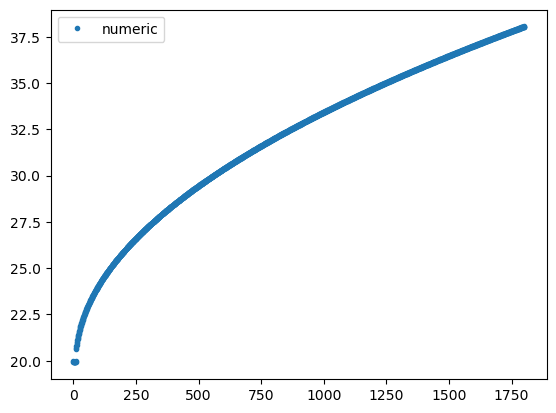

In [105]:
avg_temp_numeric = create_numeric_avtemp_fn(U, Nt_points, dx = 1/(Nx_points - 1))

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.legend()
plt.show()

In [106]:
num_tto35 = time_to_temp(avg_temp_numeric(t), 35)

print(f"{num_tto35=}")

# Find maximum average temperature
k = np.linspace(0, T, Nt_points)
for k in range(T):
    averages[k] = avg_temp_numeric(np.array([k]))

print('Maximum average temperature is :',averages.max())

num_tto35=1246.223111555778
Maximum average temperature is : 38.04769320707666


/tmp/ipykernel_5576/1072642001.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  averages[k] = avg_temp_numeric(np.array([k]))


# Observations
- This model is almost identical to the toy model
- Needs even more insulation

# Insulated Model
No sink term and a Neuman boundary condition at the top so that no heat is lost out of the top or sides. The heating element still takes time to heat up.

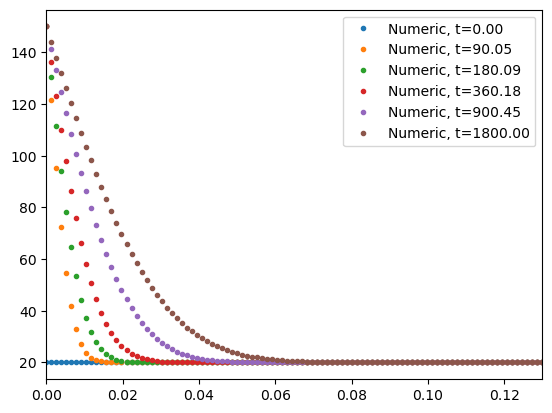

In [107]:
#b0 = 500 # Uncomment this and the one below to test constant boundary conditions

# Simulate the solution
#U = si.simulate_sink_with_fancy_bcs(u0, lambda t: b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf, True)
U = si.simulate_sink_with_fancy_bcs(u0, b0, D, T, Nt_points, L, Nx_points, a, h, kW, u_inf, True)

# Redo time functions
index_to_time = hp.create_index_to_time_fn(T, Nt_points)
time_to_index = hp.create_time_to_index_fn(T, Nt_points)

for i in (0, Nt_points//20, Nt_points//10, Nt_points//5, Nt_points//2, Nt_points - 1):
    t = index_to_time(i)
    plt.plot(x, U[:, i], ".", label = f"Numeric, {t=:.2f}")
plt.xlim(0,L)   
plt.legend()
plt.show()

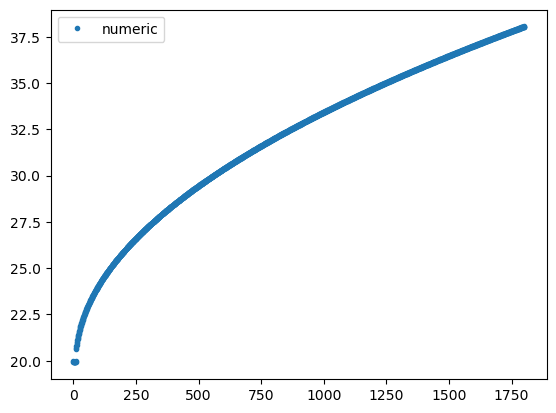

In [108]:
avg_temp_numeric = create_numeric_avtemp_fn(U, Nt_points, dx = 1/(Nx_points - 1))

t = np.linspace(0, T, Nt_points)
plt.plot(t, avg_temp_numeric(t), ".", label = "numeric")
plt.legend()
plt.show()

In [109]:
num_tto35 = time_to_temp(avg_temp_numeric(t), 35)

print(f"{num_tto35=}")

# Find maximum average temperature
k = np.linspace(0, T, Nt_points)
for k in range(T):
    averages[k] = avg_temp_numeric(np.array([k]))

print('Maximum average temperature is :',averages.max())

num_tto35=1246.223111555778
Maximum average temperature is : 38.047693207102405


/tmp/ipykernel_5576/1072642001.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  averages[k] = avg_temp_numeric(np.array([k]))


# Observations
- This model looks almost identically to the one with the Newton cooling boundary condition
- A constant bottom boundary condition temperature of 500 degrees does make the self heating can produce desirable results